In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import regularizers, layers

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from tensorflow.keras.models import Model

from time import time

In [2]:
data = pd.read_csv('./dataset/creditCardActivity/creditcard.csv', engine='pyarrow')
raw_data = data.values
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Separate normal transactions from fraudulent transactions
normal_data = data[data['Class'] == 0]
normal_data_sample = normal_data.sample(4000)
fraud_data = data[data['Class'] == 1]
fraud_data_sample = fraud_data.sample(frac=1)

# reduced_set = pd.concat([normal_data_sample, fraud_data]).reset_index(drop=True)
reduced_set = pd.concat([normal_data_sample, fraud_data_sample]).reset_index(drop=True)

# Splitting the dataset into X and y features
y_reduced = reduced_set['Class']
X_reduced = reduced_set.drop('Class', axis=1)
X_reduced = X_reduced.drop('Time', axis=1)

# X.to_json('test_data.json', orient='records')

y = data['Class']
X = data.drop('Class', axis=1)
X = X.drop('Time', axis=1)

test_normal = normal_data.drop('Class', axis=1)
test_fraud = fraud_data.drop('Class', axis=1)
test_normal = test_normal.drop('Time', axis=1)
test_fraud = test_fraud.drop('Time', axis=1)

print(f"Reduced dataset shape : {reduced_set.shape}")
print(f"Shape of Features : {X.shape} and Target: {y.shape}")

Reduced dataset shape : (4492, 31)
Shape of Features : (284807, 29) and Target: (284807,)


In [4]:
# Visualise the data
def tsne_plot(X, y):
    sns.set(style='whitegrid', palette='muted')
    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate=200)
    # Fitting the data
    X_trans = tsne.fit_transform(X)

    plt.figure(figsize=(12, 8))

    plt.scatter(X_trans[np.where(y == 0), 0], X_trans[np.where(y == 0), 1], marker='o', color='blue', linewidth=1, alpha=0.8, label='Normal')
    plt.scatter(X_trans[np.where(y == 1), 0], X_trans[np.where(y == 1), 1], marker='o', color='orange', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best')

    plt.show()

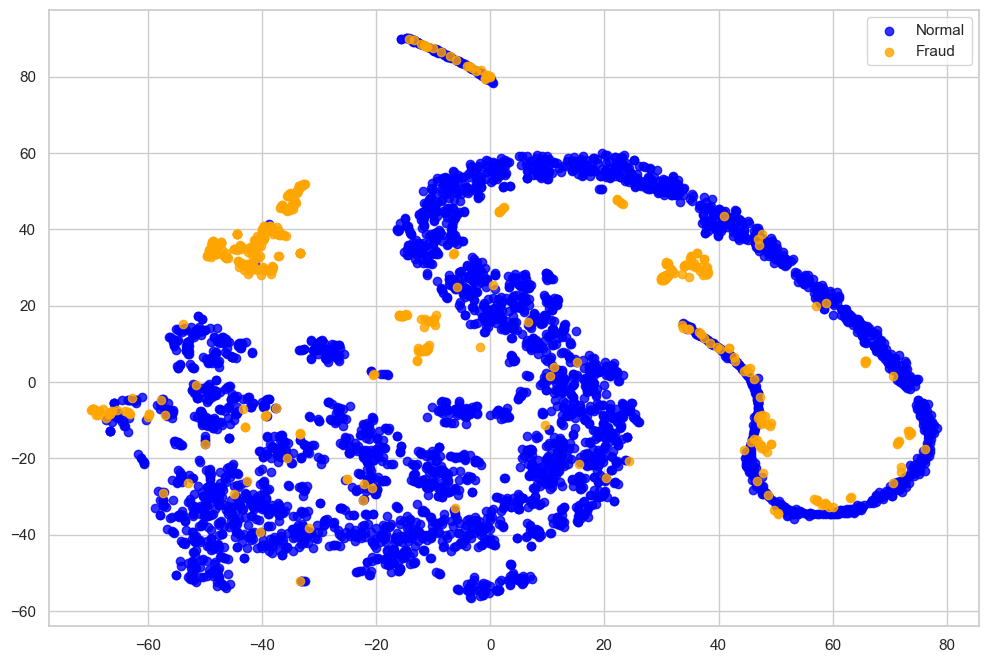

In [5]:
tsne_plot(X_reduced, y_reduced)

In [6]:
# Drop Time
data = data.drop(['Time'], axis=1)

train_x, test_x = train_test_split(data, test_size=0.2, random_state=736)
train_x = train_x[train_x['Class'] == 0]    # train only on normal transactions data
train_x = train_x.drop(['Class'], axis=1)   # drop the class column

test_x_normal = test_x[test_x['Class'] == 0].sample(5000)
test_x_normal = test_x_normal.drop(['Class'], axis=1).values
test_x_fraud = test_x[test_x['Class'] == 1]
test_x_fraud = test_x_fraud.drop(['Class'], axis=1).values

test_normal_sample = normal_data_sample.drop(['Class'], axis=1)
test_fraud_sample = fraud_data.drop(['Class'], axis=1)
# test_normal_sample = normal_data_sample.drop(['Time'], axis=1)
# test_fraud_sample = fraud_data.drop(['Time'], axis=1)

test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

test = test_x.sample(1)

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [7]:
hyperparams = {
    "epochs": 20,
    "batch_size": 32
}

In [8]:
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_logical_devices('GPU'))
print(tf.config.list_logical_devices('CPU'))

print("TensorFlow version: {}".format(tf.__version__))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
TensorFlow version: 2.10.0
Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-29 20:33:00.520132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-29 20:33:00.520322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Build the model :)
class FraudDetector(Model):

    def __init__(self):
        super(FraudDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(29, input_shape=(29, )),
            layers.Dense(14, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(7, activation='tanh', activity_regularizer=regularizers.l1(1e-7))]
        )

        self.decoder = tf.keras.Sequential([
            layers.Dense(14, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(29, activation='relu')]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, encoded_x):
        return self.decoder(encoded_x)

In [8]:
autoencoder = FraudDetector()

# Compule the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mse')

# Train the model
history = autoencoder.fit(x=train_x, y=train_x,
                          batch_size=hyperparams['batch_size'],
                          epochs=hyperparams['epochs'],
                          shuffle=True,
                          validation_data=(test_x, test_x))

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/20


2023-05-27 15:51:53.949009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-27 15:51:53.949197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-27 15:51:54.117208: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-27 15:51:54.473517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7108/7108 [==============================] - ETA: 0s - loss: 2196.0244 - accuracy: 0.8752

2023-05-27 15:52:43.139769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7108/7108 [==============================] - 55s 8ms/step - loss: 2196.0244 - accuracy: 0.8752 - val_loss: 2030.0905 - val_accuracy: 0.8771
Epoch 2/20
7108/7108 [==============================] - 55s 8ms/step - loss: 1902.8197 - accuracy: 0.8865 - val_loss: 1787.8760 - val_accuracy: 0.8829
Epoch 3/20
7108/7108 [==============================] - 53s 8ms/step - loss: 1700.4478 - accuracy: 0.8845 - val_loss: 1613.7357 - val_accuracy: 0.8824
Epoch 4/20
7108/7108 [==============================] - 52s 7ms/step - loss: 1553.9598 - accuracy: 0.8865 - val_loss: 1480.2369 - val_accuracy: 0.8829
Epoch 5/20
7108/7108 [==============================] - 51s 7ms/step - loss: 1439.7847 - accuracy: 0.8758 - val_loss: 1375.0573 - val_accuracy: 0.8804
Epoch 6/20
7108/7108 [==============================] - 51s 7ms/step - loss: 1345.4609 - accuracy: 0.8782 - val_loss: 1285.3031 - val_accuracy: 0.8816
Epoch 7/20
7108/7108 [==============================] - 51s 7ms/step - loss: 1266.3215 - accuracy: 0.8776

In [9]:
autoencoder.summary(expand_nested=True)

Model: "fraud_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 7)                 1395      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dense (Dense)             (None, 29)                870       |
|                                                               |
| dense_1 (Dense)           (None, 14)                420       |
|                                                               |
| dense_2 (Dense)           (None, 7)                 105       |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_1 (Sequential)   (None, 29)                547       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dense_3 (Dense)           (None, 14)                112       |
|                                                               |
| dense_4 (Dense)           (None, 29)              

In [10]:
ts = int(time())
filepath = f'../models/fraud_detector/{ts}'
autoencoder.save(filepath=filepath, save_format='tf')

INFO:tensorflow:Assets written to: ../models/fraud_detector/1685195403/assets


In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [10]:
filepath = f'../models/fraud_detector/1685195403'
model = tf.keras.models.load_model(filepath)

In [12]:
test_normal_sample = test_normal_sample.drop('Time', axis=1)
test_fraud_sample = test_fraud_sample.drop('Time', axis=1)

normal_points = model.predict(test_normal_sample)
fraud_points = model.predict(test_fraud_sample)

# normal_points = model.predict(test_x_normal)
# fraud_points = model.predict(test_x_fraud)

# normal_points = model.predict(test_normal)
# fraud_points = model.predict(test_fraud)

encoded_X = np.append(normal_points, fraud_points, axis=0)
y_normal = np.zeros(normal_points.shape[0])
y_fraud = np.ones(fraud_points.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

 80/125 [==================>...........] - ETA: 0s

2023-05-29 20:33:29.151641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


2023-05-29 20:33:29.510727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


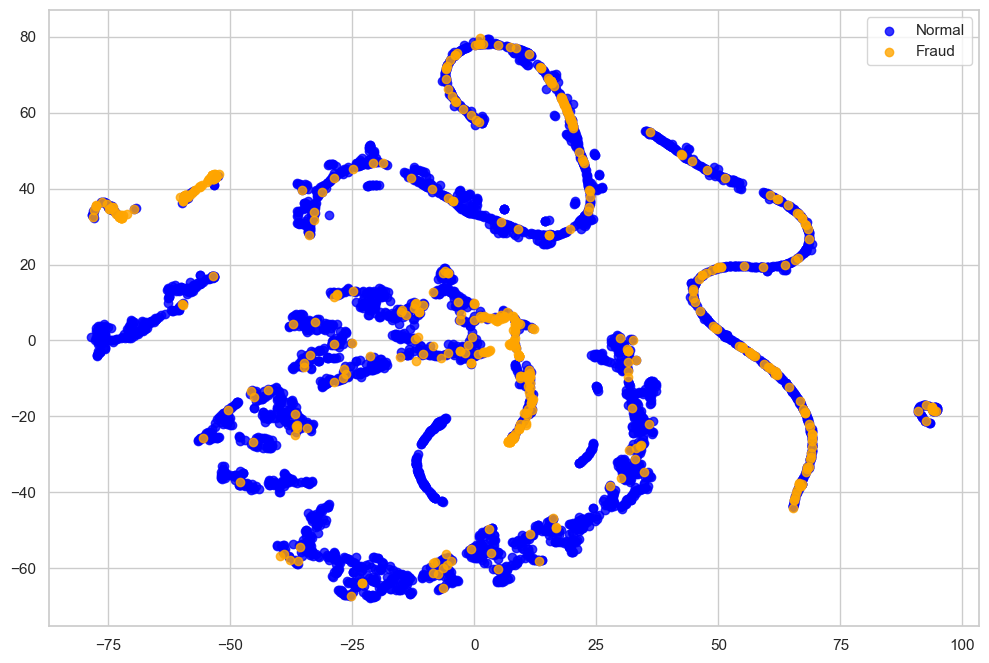

In [13]:
tsne_plot(encoded_X, encoded_y)

In [14]:
normal_points = model.predict(test_normal_sample)
fraud_points = model.predict(test_fraud_sample)

mse = np.mean(np.square(test_fraud_sample - fraud_points), axis=1)
mse

16/16 [==============================] - 0s 2ms/step


541        3.555218
623        2.925045
4920       3.642151
6108      17.508405
6329       5.139032
            ...    
279863     6.887306
280143     3.944459
280149     3.031470
281144     6.680482
281674     0.740518
Length: 492, dtype: float64

In [15]:
predictions = model.predict(test_x)
mse = np.mean(np.power(test_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test_y})
error_df.describe()


  79/1781 [>.............................] - ETA: 3s

2023-05-29 20:33:52.406297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1781/1781 [==============================] - 3s 2ms/step


,reconstruction_error,true_class
count,5.696200e+04,56962.000000
mean,7.388419e+02,0.001562
std,2.758726e+04,0.039497
min,1.053135e-01,0.000000
25%,3.872286e-01,0.000000
50%,5.916138e-01,0.000000
75%,8.781919e-01,0.000000
max,4.101905e+06,1.000000


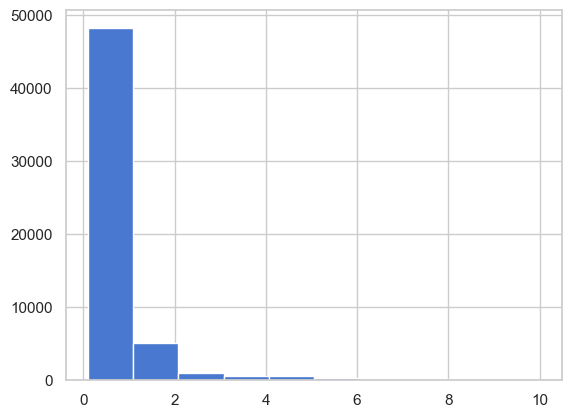

In [16]:
# Reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

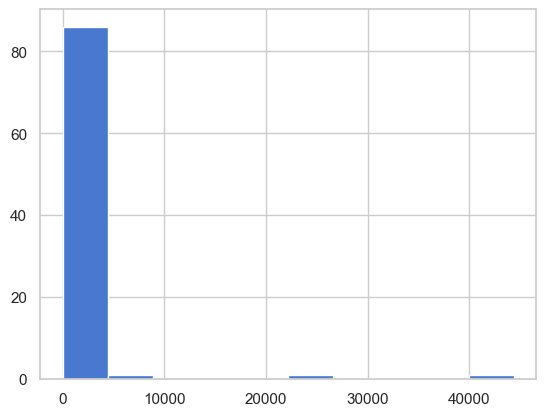

In [17]:
# Reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

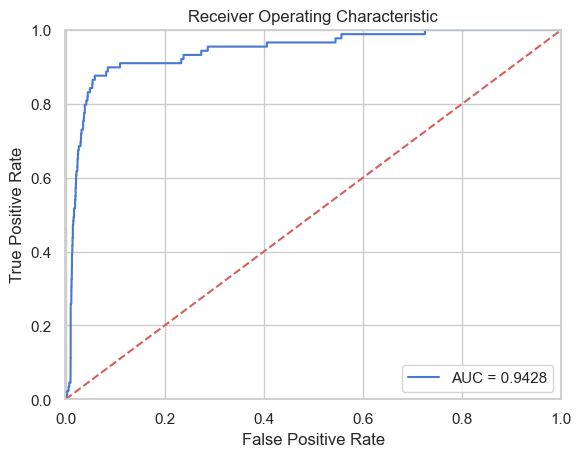

In [18]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

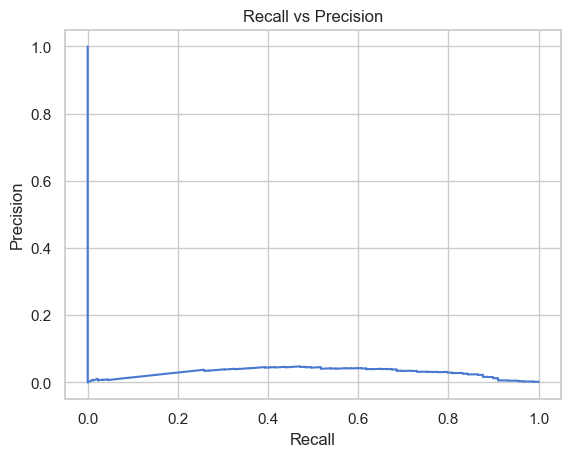

In [19]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

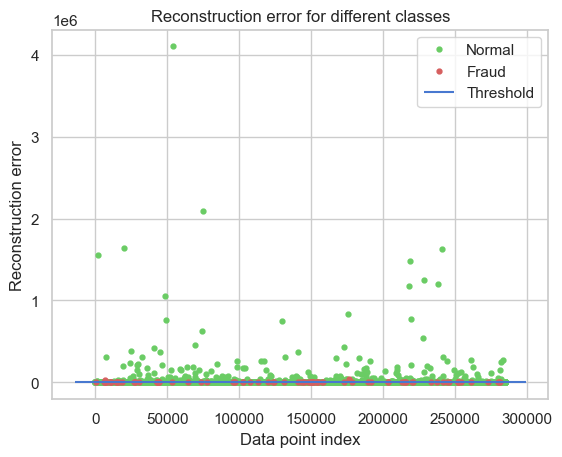

In [20]:
# Prediction analysis

error_threshold = 2.9

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', color="r" if name == 1 else "g", ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(error_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="b", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

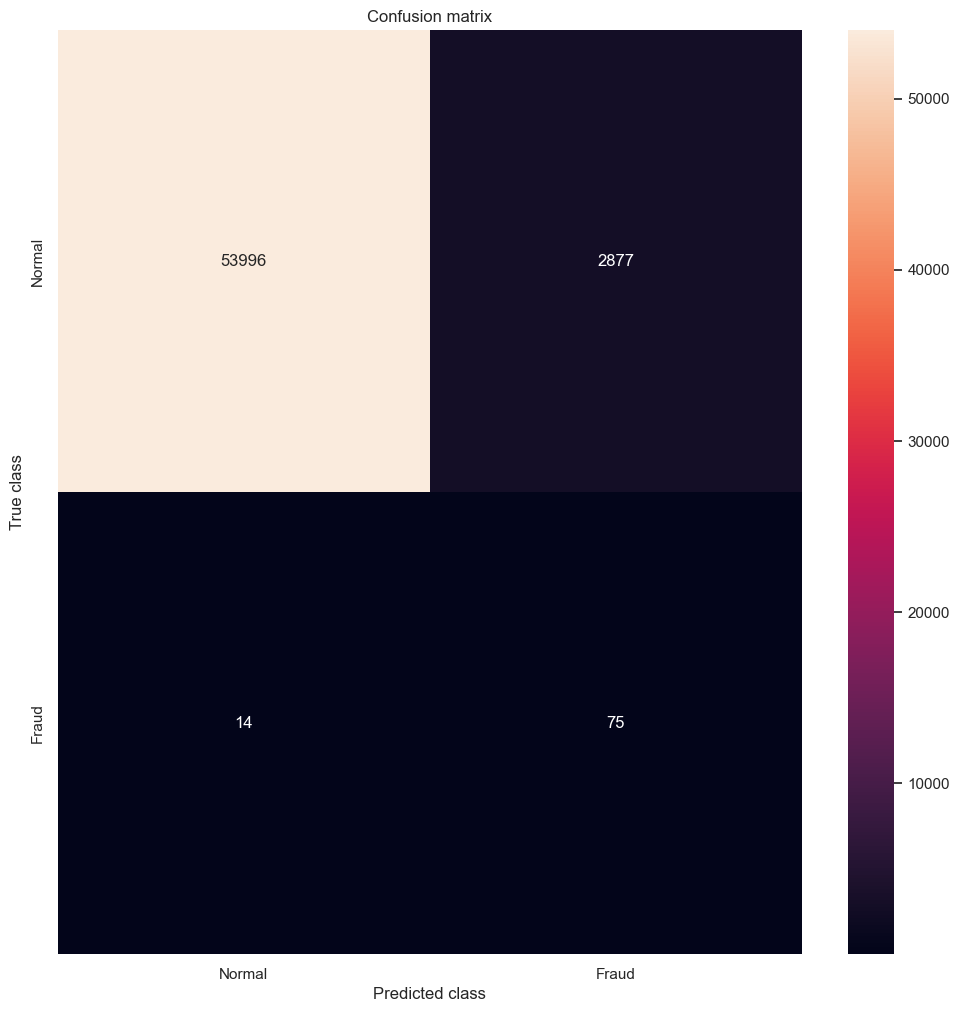

In [21]:
# confusion matrix

y_pred = [1 if e > error_threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
### failed models
# Build the model :)
class deprecated_FraudDetector(Model):

    def __init__(self):
        super(deprecated_FraudDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(18, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(10, activation='relu'),
            layers.Dense(6, activation='tanh', activity_regularizer=regularizers.l1(1e-7))])

        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(18, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(30, activation='relu')]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Build the model :)
class deprecated_SimpleDetector(Model):

    def __init__(self):
        super(deprecated_SimpleDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(30, activation='relu', input_shape=(30, )),
            layers.Dense(14, activation='relu'),
            layers.Dense(7, activation='relu')]
        )

        self.decoder = tf.keras.Sequential([
            layers.Dense(14, activation='relu'),
            layers.Dense(30, activation='relu')]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded